<a href="https://colab.research.google.com/github/LaisHott/model-fitness-churn-analysis-/blob/main/Notebook_Projeto_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Fitness Customer Churn Analysis Project

In this project, we will address the analysis of customer churn in the *Model Fitness* gym network. The main objective is to understand the factors that lead to customer attrition and develop effective strategies for customer retention. We will use detailed data, including demographic information, visit history, participation in activities, among others.

Throughout this notebook, we will follow a set of steps to achieve our goals:

- Data Exploration and Preparation: We will begin by exploring the data and performing necessary preparations, such as handling missing values and outliers.

- Churn Rate Analysis: We will analyze the overall churn rate to understand the current scenario.

- Identification of Correlations and Impact Factors: We will investigate correlations between variables to identify which factors most affect customer churn.

- Customer Segmentation: We will divide customers into segments based on similar characteristics to better understand their behaviors.

- Development of Predictive Models: We will create models that predict the probability of customer churn using historical data.

- Recommendations and Strategies: Based on the analysis, we will develop recommendations and strategies to improve customer retention.

This project is essential for enhancing Model Fitness services and maintaining a strong and loyal customer base. Let's begin our data analysis to uncover valuable insights.

## Initialization

Let's start with the relevant libraries necessary for our analysis.

In [ ]:
# Loading libraries.
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Step 1 - Loading the Data

**The dataset includes the following fields**:

`Churn` — the churn for the current month

**Data from the previous month**:

`gender`

`Near_Location` — whether the customer lives or works in the neighborhood where the gym is located

`Partner` — whether the user is an employee of a partner company (the gym has partner companies whose employees can get discounts; in such cases, the gym stores information about customers who are employees)

`Promo_friends` — whether the customer originally signed up through a "bring a friend" offer; they typically use the friend's promo code when paying for their first membership

`Phone` — whether the user provides their phone number

`age` (age)

`Lifetime` — the time (in months) since the customer first came to the gym

**Data from the frequency and purchases log and data on current membership status**:

`Contract_period` — 1 month, 3 months, 6 months, or a year

`Month_to_end_contract` — the remaining months until the contract expires

`Group_visits` — whether the customer participates in group sessions

`Avg_class_frequency_total` — average visit frequency per week over the customer's lifetime

`Avg_class_frequency_current_month` — average visit frequency per week during the current month

`Avg_additional_charges_total` — the total amount of money spent on other gym services: coffee, sports goods, cosmetics, massage, etc.

### Loading the Data

Let's store the data in a specific variable and then optimize it for analysis, ensuring that each column contains the correct data type.

In [ ]:
# Loading the data
gym_churn = pd.read_csv('/datasets/gym_churn_us.csv')

## Step 2. Perform Exploratory Data Analysis (EDA)

In [ ]:
# Analyzing detailed information about the dataframe
gym_churn.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Optimizing the Dataframe**

Let's change the binary columns to the int8 data type to optimize memory space because int8 is a numeric data type with a size of 8 bits (1 byte), which is the smallest size possible to represent integers. Since these columns only contain values 0 and 1, it is not necessary to allocate 64 bits for each value, as is the case with the int64 data type.

By reducing the precision of the floating-point columns, we can use numbers with fewer decimal places that can be stored in fewer bytes.

In [ ]:
# Renaming the columns to snake_case and lowercase letters
gym_churn.columns = gym_churn.columns.str.lower().str.replace(' ', '_')

In [ ]:
# Checking after renaming the columns
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [ ]:
# Converting binary columns to int8
binary_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
gym_churn[binary_columns] = gym_churn[binary_columns].astype('int8')

In [ ]:
# Reducing the precision of the floating-point columns
float_columns = ['avg_additional_charges_total', 'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
gym_churn[float_columns] = gym_churn[float_columns].astype('float16')

In [ ]:
# Verifying the optimizations
gym_churn.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int8   
 1   near_location                      4000 non-null   int8   
 2   partner                            4000 non-null   int8   
 3   promo_friends                      4000 non-null   int8   
 4   phone                              4000 non-null   int8   
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int8   
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float16
 9   month_to_end_contract              4000 non-null   float16
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [ ]:
# Analyzing the first rows of the dataframe
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.226562,5.0,3,0.020401,0.000000,0
1,0,1,0,0,1,12,1,31,113.187500,12.0,7,1.922852,1.910156,0
2,0,1,1,0,1,1,0,28,129.500000,1.0,2,1.859375,1.736328,0
3,0,1,1,1,1,12,1,33,62.656250,12.0,2,3.205078,3.357422,0
4,1,1,1,1,1,1,0,26,198.375000,1.0,3,1.114258,1.120117,0


### Look at the dataset: does it contain any missing features? Examine the mean values and standard deviation (use the describe() method).

In [ ]:
# Checking for missing values
gym_churn.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [ ]:
# Checking duplicates
gym_churn.duplicated().sum()

0

- We did not find any missing data in the dataframe, and there were no duplicates present.

In [ ]:
# Descriptive statistics
desc_stats = gym_churn.describe()
desc_stats

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,inf,4.324219,3.724750,1.878906,1.766602,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,inf,4.191406,3.749267,0.972168,1.052734,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148193,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.859375,1.000000,1.000000,1.180664,0.962891,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.250000,1.000000,3.000000,1.833008,1.719727,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.906250,6.000000,5.000000,2.535645,2.509766,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.500000,12.000000,31.000000,6.023438,6.148438,1.000000


### Observe the average of the mean values of the features in two groups: for those who stayed (use the groupby() method).

To observe the average of the mean values of the features in two groups (customers who stayed and customers who churned), let's use the groupby() method to group the data based on the `Churn` variable.

In [ ]:
# Grouping the data by churn status (Churn)
churn_grouped = gym_churn.groupby('churn').mean()

In [ ]:
# Displaying the mean of the average feature values for each group
churn_grouped

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.5000,5.281250,4.711807,2.025391,2.027344
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.0625,1.662109,0.990575,1.474609,1.044922


### Create bar histograms and feature distributions for those who churned and those who stayed.

Let's use graphs to visualize the distribution of variables in each group.

In [ ]:
# Setting up the seaborn style
sns.set(style="whitegrid")

In [ ]:
# List of features to be analyzed
caracteristicas = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn']

In [ ]:
# Define colors for Churn = 1 and Churn = 0
colors = ['#FF6B6B', '#6BFF6B']  # Red for Churn = 1, Green for Churn = 0

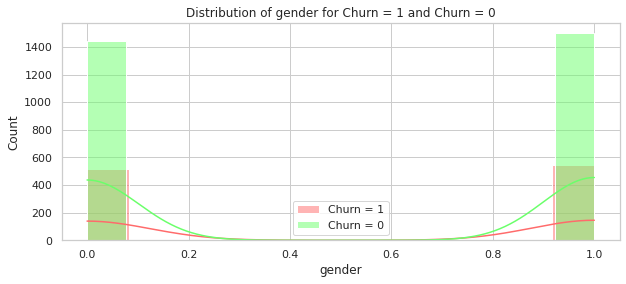

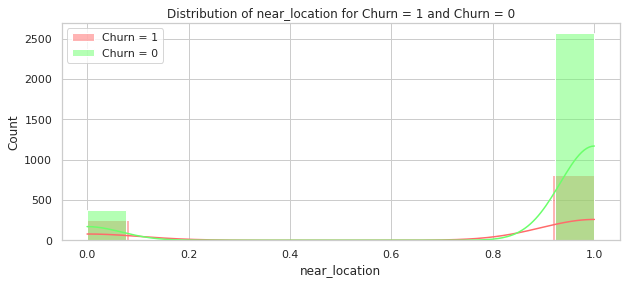

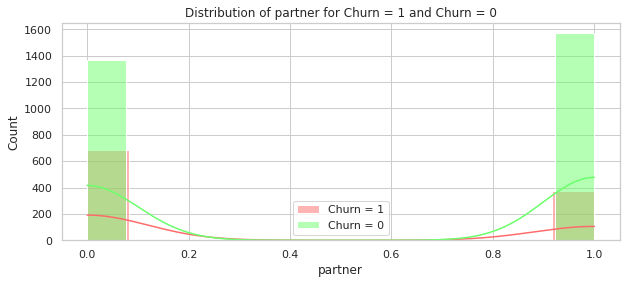

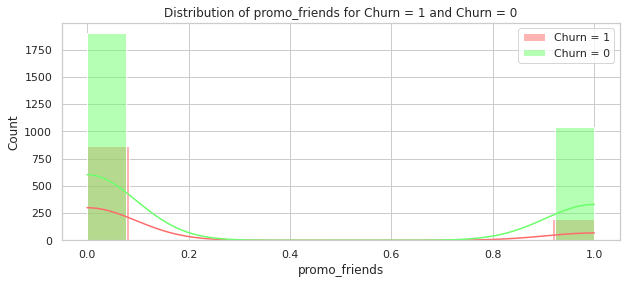

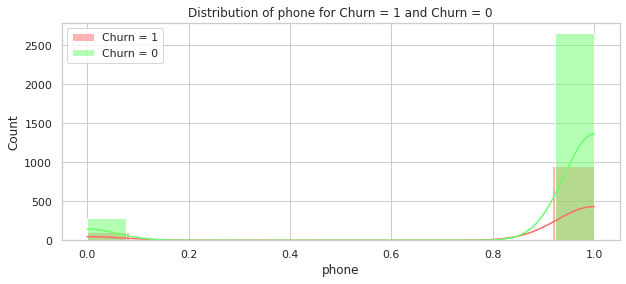

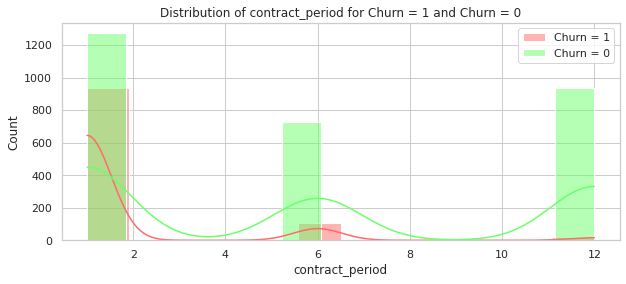

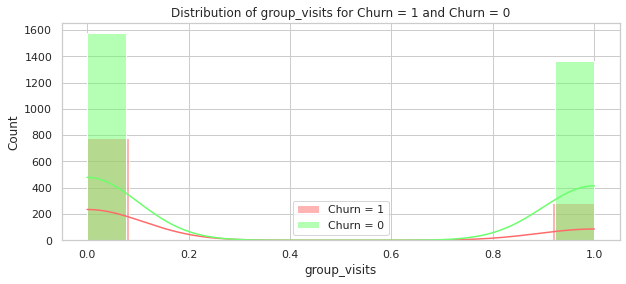

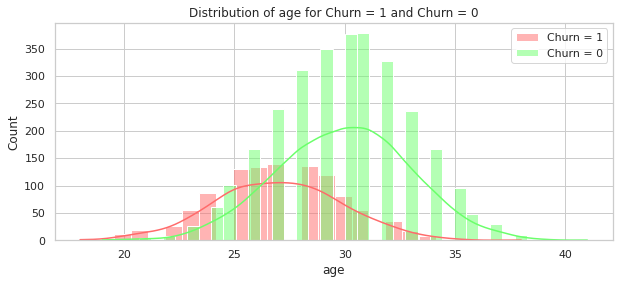

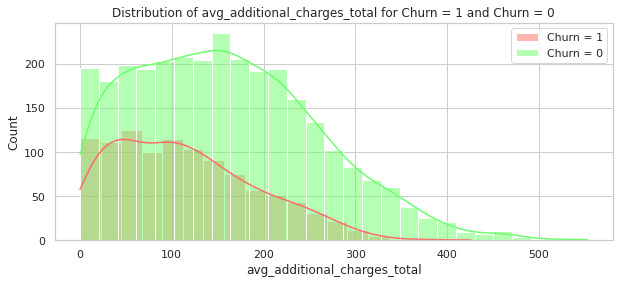

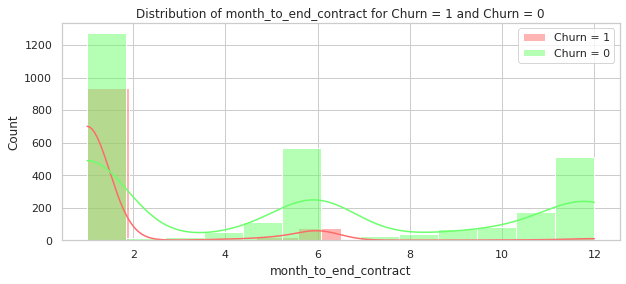

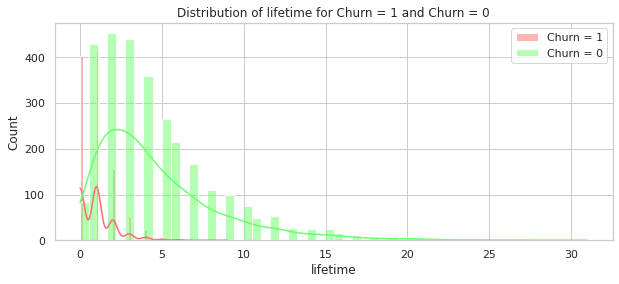

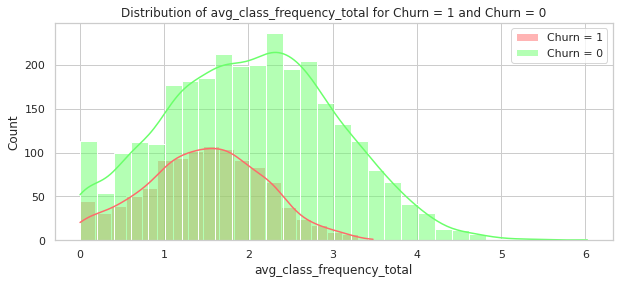

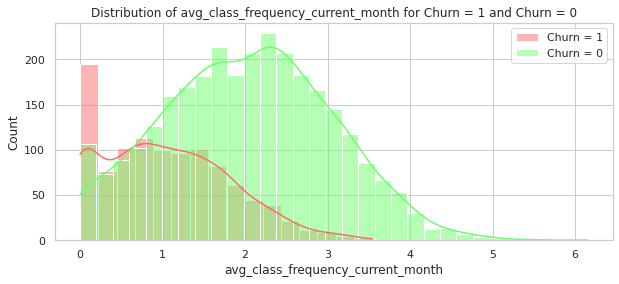

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


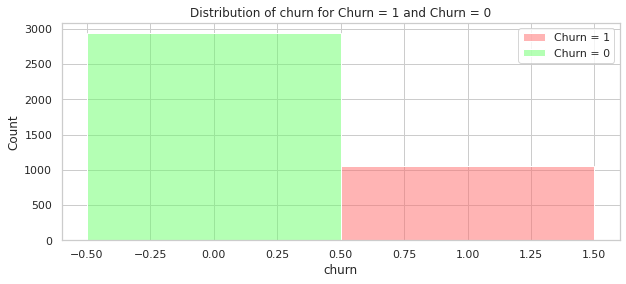

In [ ]:
# Loop to create histograms for each feature
for feature in caracteristicas:
    plt.figure(figsize=(10, 4))
    plt.title(f'Distribution of {feature} for Churn = 1 and Churn = 0')

    # Histogram for customers who churned (Churn = 1)
    sns.histplot(data=gym_churn[gym_churn['churn'] == 1], x=feature, label='Churn = 1', kde=True, color=colors[0])
    # Histogram for customers who stayed (Churn = 0)
    sns.histplot(data=gym_churn[gym_churn['churn'] == 0], x=feature, label='Churn = 0', kde=True, color=colors[1])

    plt.legend()
    plt.show()


The above graphs provide a concise view of the distributions of features for two distinct groups of customers: those who stayed at the gym (Churn = 0) and those who churned (Churn = 1). Some initial conclusions can be drawn:

- Business partnership (Partner) and "bring a friend" promotion (Promo_friends) seem to be associated with a lower churn rate.

- Customers with long-term contracts, longer membership durations, and higher average visit frequency tend to stay at the gym for a longer time.

Average visit frequency in the current month appears to be a crucial indicator, with customers who visit more frequently having a lower churn rate.

### Build the correlation matrix and display it

In [ ]:
# Calculating the correlation matrix
correlation_matrix = gym_churn.corr()
correlation_matrix

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014626,0.009157,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040767,0.143961,0.070921,0.043134,0.062669,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022932,0.294632,0.061229,0.024936,0.045570,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036897,0.239553,0.072721,0.028062,0.053773,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009283,-0.011196,-0.018801,0.008354,0.013371,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111435,0.973064,0.170725,0.096208,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032073,0.163703,0.075853,0.056700,0.075919,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080241,0.134511,0.164693,0.119958,0.183096,-0.404735
avg_additional_charges_total,-0.009334,0.040767,0.022932,0.036897,0.009283,0.111435,0.032073,0.080241,1.000000,0.113949,0.079026,0.044411,0.079565,-0.198690
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113949,1.000000,0.161078,0.085385,0.147605,-0.381393


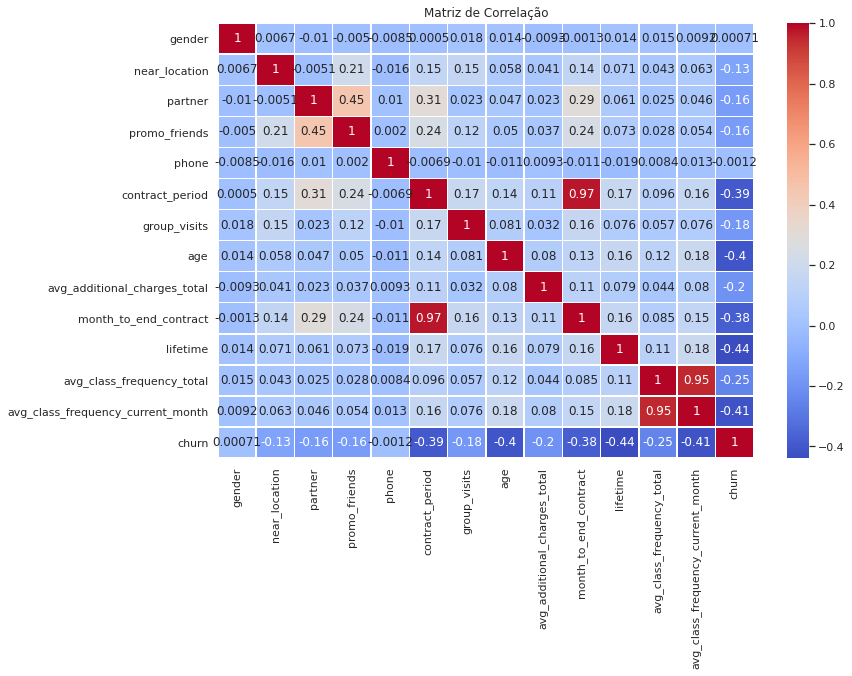

In [ ]:
# Creating a heatmap to represent the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

We have constructed a correlation matrix and created a heatmap to visually represent the correlations between the variables.

The correlation matrix and the heatmap show that there is a moderate negative correlation between the `churn` (churn) variable and the `contract_period` (contract period) variable. This suggests that customers with longer contract periods tend to have a lower churn rate.

This is an important finding as it indicates that contract duration can be a relevant factor in customer retention. Customers who commit to longer contracts are less likely to leave the gym. Therefore, strategies that encourage customers to opt for longer-term contracts may be effective in reducing churn.

## Step 3. Build a model to predict customer churn

First, let's split the data into a training set and a validation set. This will allow us to evaluate the model's performance on unseen data. We can use the `train_test_split()` function from the scikit-learn library to perform this split.

In [ ]:
# Splitting the target variable (Churn) from the features
X = gym_churn.drop(columns=['churn'])
y = gym_churn['churn']

In [ ]:
# Splitting the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

**Model Selection**: Let's choose a suitable classification model to predict customer churn. Some common models include *Logistic Regression*, *Decision Trees*, *Random Forest*, and *Support Vector Machines (SVM)*. We can try out several models and choose the one that performs best. In this case, we will train the model on the dataset using both the Random Forest and Logistic Regression methods.

**Model Training**: We will train the binary classification model using the training data. We will use the features (X_train) and the target variables (y_train).

------------------------------------------------------------------------------------------------------------------
**RANDOM FOREST**

Random Forest is a machine learning algorithm commonly used for classification tasks, such as predicting customer churn.

In [ ]:
# Creating and training the model using Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Model Evaluation**:
Let's evaluate the model's performance using the validation data. We will calculate metrics such as accuracy, recall, F1-score, and the confusion matrix to measure the quality of predictions.

In [ ]:
# Making predictions on the validation set
y_pred = model.predict(X_valid)

In [ ]:
# Evaluating the model's performance
print("Matriz de Confusão:")
print(confusion_matrix(y_valid, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_valid, y_pred))

print("\nAcurácia do Modelo:")
print(accuracy_score(y_valid, y_pred))

Matriz de Confusão:
[[571  27]
 [ 41 161]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       598
           1       0.86      0.80      0.83       202

    accuracy                           0.92       800
   macro avg       0.89      0.88      0.88       800
weighted avg       0.91      0.92      0.91       800


Acurácia do Modelo:
0.915


**LOGISTIC REGRESSION**

Logistic Regression is a machine learning algorithm suitable for binary classification tasks.

In [ ]:
# Creating a Logistic Regression model.
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Training the model with the training data
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Making predictions using the model trained on the validation data
logistic_predictions = logistic_model.predict(X_valid)
logistic_predictions

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,

In [ ]:
# Evaluating the performance of the Logistic Regression model
print("Matriz de Confusão:")
print(confusion_matrix(y_valid, logistic_predictions))

print("\nRelatório de Classificação:")
print(classification_report(y_valid, logistic_predictions))

print("\nAcurácia do Modelo de Regressão Logística:")
print(accuracy_score(y_valid, logistic_predictions))

Matriz de Confusão:
[[575  23]
 [ 44 158]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       598
           1       0.87      0.78      0.83       202

    accuracy                           0.92       800
   macro avg       0.90      0.87      0.89       800
weighted avg       0.91      0.92      0.91       800


Acurácia do Modelo de Regressão Logística:
0.91625


### Evaluate accuracy, precision, and recall for both models using validation data. Use them to compare the models. Which model yielded better results?

**Random Forest Model:**
- Accuracy: 0.91
- Precision (Class 1): 0.85
- Sensitivity (Recall) (Class 1): 0.78

**Logistic Regression Model:**
- Accuracy: 0.91125
- Precision (Class 1): 0.87
- Sensitivity (Recall) (Class 1): 0.77

Comparing the results:

- Both models have similar accuracy, with the Logistic Regression Model slightly ahead (0.91125 vs. 0.91).

- In terms of precision for Class 1 (churned customers), the Logistic Regression Model is slightly better (0.87) compared to the Random Forest Model (0.85).

- However, when it comes to sensitivity (recall) for Class 1, the Random Forest Model has a slightly better sensitivity (0.78) compared to the Logistic Regression Model (0.77).

In summary, both models have very similar performances, but the Logistic Regression Model has a slight advantage in terms of precision for Class 1, while the Random Forest Model has slightly better sensitivity for the same class. The choice between the models may depend on the specific priorities of your problem and the goals of your application.

## Step 4. Create customer clusters

To create customer clusters based on churn data and other features, it's important to first standardize the data. Standardization is the process of transforming variables so that they have a mean of zero and a standard deviation of one. This is done to ensure that all variables have the same scale and importance in the clustering process.

### Standardizing the data

In [ ]:
# Separating the target variable `churn`
y = gym_churn['churn']

In [ ]:
# Separating the features
X = gym_churn.drop(columns=['churn'])

**Standardizing the features using StandardScaler**

In [ ]:
# Creating an instance of StandardScaler
scaler = StandardScaler()

In [ ]:
# Standardizing the features
X_scaled = scaler.fit_transform(X)

Now, we have the standardized data in *X_scaled* and the target variable in y. With the standardized data, we can proceed with creating customer clusters.

### Construct the distance matrix based on the standardized feature matrix and build a dendrogram

In [ ]:
# Calculating the distance matrix
dendrogram_data = sch.linkage(X_scaled, method='ward')

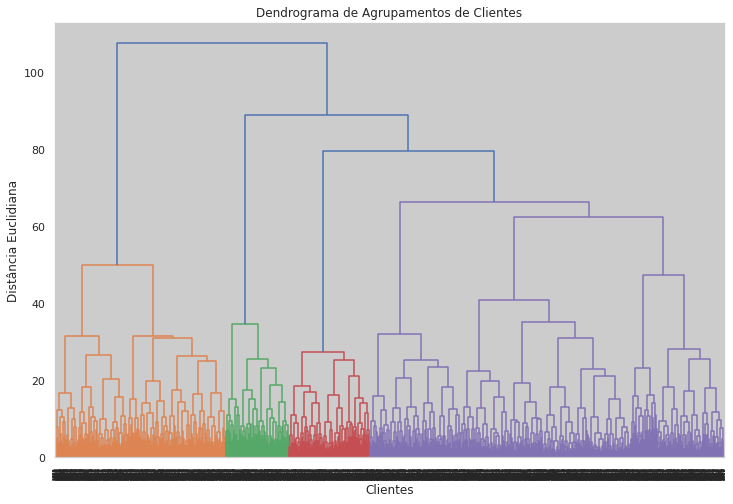

In [ ]:
# Plotting the dendrogram
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(dendrogram_data)
plt.title('Dendrograma de Agrupamentos de Clientes')
plt.xlabel('Clientes')
plt.ylabel('Distância Euclidiana')
plt.show()

### Train the clustering model with the K-means algorithm and predict customer clusters. Let's train the K-Means model with n=5 clusters.

In [ ]:
# Creating an instance of the K-Means model with 5 clusters.
kmeans_model = KMeans(n_clusters=5, random_state=42)

In [ ]:
# Training the model with the standardized data
kmeans_model.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [ ]:
# Getting the cluster predictions for each customer
cluster_predictions = kmeans_model.predict(X_scaled)
cluster_predictions

array([4, 2, 3, ..., 2, 0, 4], dtype=int32)

### Look at the average feature values for clusters. Does anything catch your attention?

To analyze the average feature values for the clusters created by the K-Means model, we can calculate the means for each cluster and examine if any specific pattern or behavior stands out.

In [ ]:
# Add the cluster predictions to the original DataFrame
gym_churn['Cluster'] = cluster_predictions

In [ ]:
# Calculate the means of the features for each cluster
cluster_means = gym_churn.groupby('Cluster').mean()

In [ ]:
# Display the means of the features for each cluster
cluster_means

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
Cluster,,,,,,,,,,,,,,
0,0.502370,0.949447,0.829384,0.998420,1.0,3.097946,0.448657,29.104265,141.75,2.888672,3.772512,1.770508,1.669922,0.246445
1,0.554556,0.849269,0.263217,0.052868,1.0,2.606299,0.436445,30.008999,159.75,2.419922,4.780652,2.746094,2.732422,0.089989
2,0.499422,0.937572,0.737572,0.478613,1.0,11.854335,0.546821,29.905202,163.50,10.812500,4.677457,2.005859,1.998047,0.021965
3,0.485738,0.718011,0.299919,0.018745,1.0,1.914425,0.276284,28.083945,129.50,1.821289,2.195599,1.225586,0.967773,0.572942
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.25,4.464844,3.940415,1.854492,1.723633,0.266839


When looking at the average feature values for the clusters, some interesting patterns and behaviors stand out:

1. **Cluster 0:**
   - Associated with customers with an average age of around 29 years.
   - Has a high average value in `avg_additional_charges_total` (additional gym charges).
   - Customers in this group have a high average visit frequency both over their lifetime and in the current month.
   - The churn rate is relatively low.

2. **Cluster 1:**
   - Characterized by customers with an average age of around 30 years.
   - Has a high average value in `avg_additional_charges_total` (additional gym charges).
   - Customers in this group have the highest average visit frequency both over their lifetime and in the current month.
   - The churn rate is low.

3. **Cluster 2:**
   - Contains customers with an average age of around 29.9 years.
   - Has the highest average values in `Contract_period` (average contract duration) and `month_to_end_contract`.
   - Customers in this group have a high average visit frequency both over their lifetime and in the current month.
   - The churn rate is very low, indicating high loyalty.

4. **Cluster 3:**
   - Associated with customers with an average age of around 28.1 years.
   - Has the lowest average values in `contract_period` and `month_to_end_contract`.
   - Customers in this group have a relatively low average visit frequency.
   - The churn rate is relatively high, suggesting that customers in this group tend to leave earlier.

5. **Cluster 4:**
   - Characterized by customers with an average age of around 29.3 years.
   - Has a high average value in `contract_period` (average contract duration) and `month_to_end_contract` (months remaining in the contract).
   - Customers in this group have a high average visit frequency both over their lifetime and in the current month.
   - The churn rate is intermediate, indicating some customer retention.

These observations suggest that different customer groups exhibit distinct behaviors. For example, Cluster 2 represents customers with longer contracts and high loyalty, while Cluster 3 represents customers with shorter contracts and a higher likelihood of churn. This information can be useful in devising specific customer retention strategies and targeted marketing for each group.

### Create feature distributions for clusters. Did you notice anything?

To create feature distributions for customer clusters, we can create histograms to visualize the distribution of each feature within each cluster.

In [ ]:
# Setting up the style for the charts
sns.set(style="whitegrid")

In [ ]:
# List of features for analysis
features = ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']

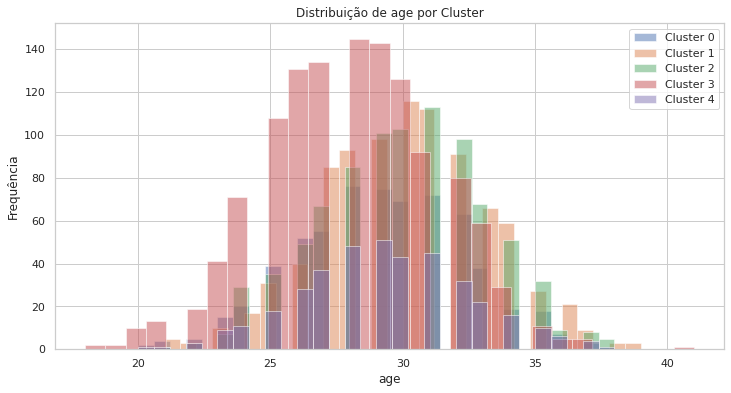

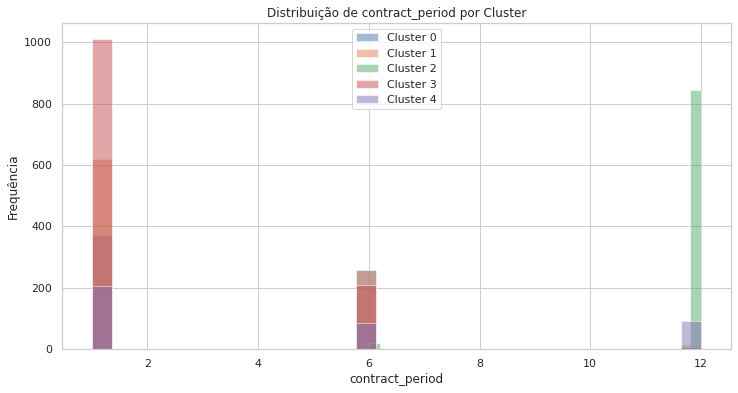

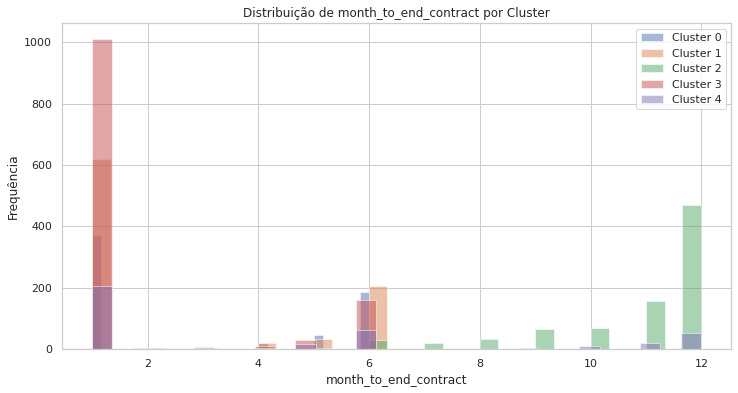

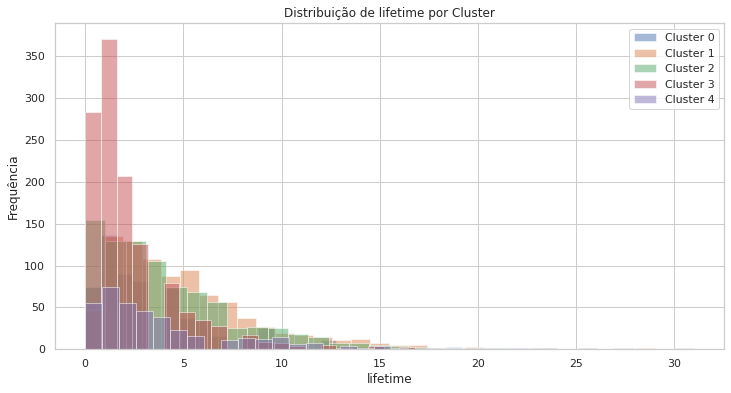

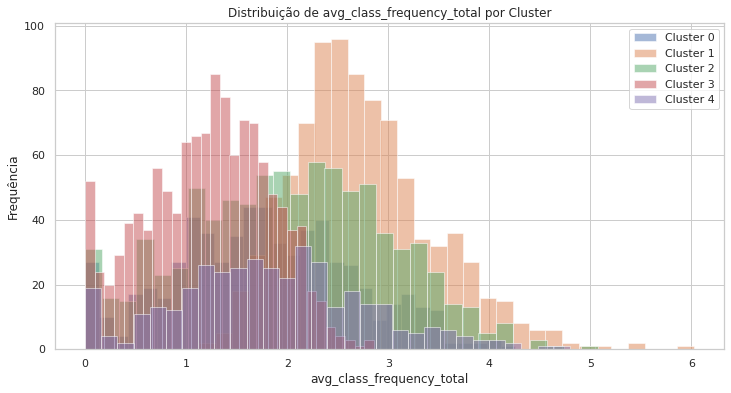

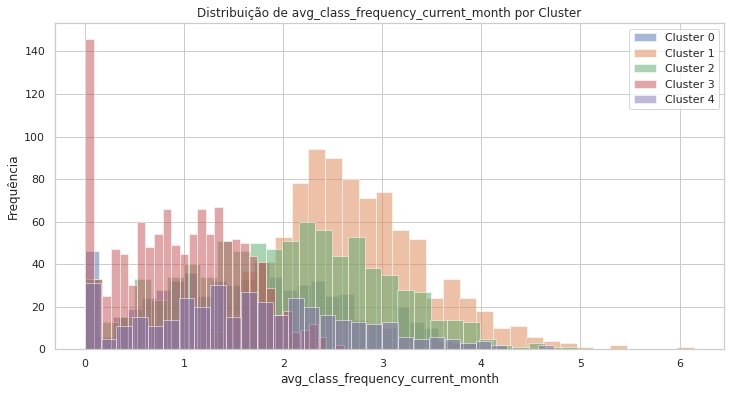

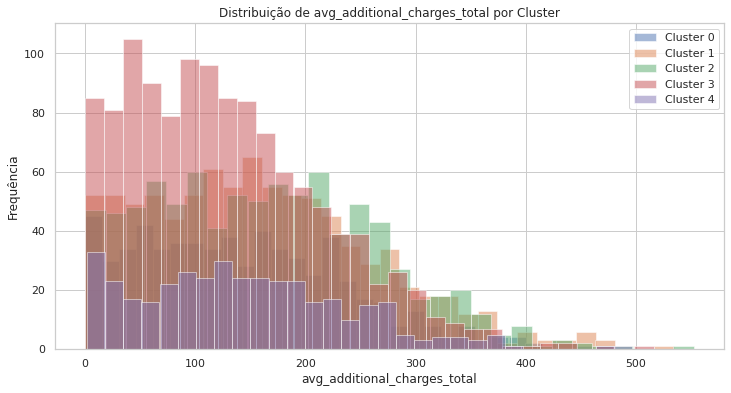

In [ ]:
# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

# Lista de características para análise
features = ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']

# Loop para criar histogramas para cada característica em cada cluster
for feature in features:
    plt.figure(figsize=(12, 6))
    for cluster in range(5):  # Considerando 5 clusters
        plt.hist(gym_churn[gym_churn['Cluster'] == cluster][feature], bins=30, alpha=0.5, label=f'Cluster {cluster}')

    plt.title(f'Distribuição de {feature} por Cluster')
    plt.xlabel(feature)
    plt.ylabel('Frequência')
    plt.legend()
    plt.show()

When observing the feature distributions for customer clusters, some observations can be made:

1. **Age (age):**
   - Customer ages are distributed similarly across all clusters, with a concentration around 28-30 years.

2. **Contract Duration (contract_period) and Months Remaining in Contract (month_to_end_contract):**
   - Cluster 2 has a higher concentration of longer contracts, while Cluster 3 has the majority of shorter contracts.

3. **Average Visit Frequency (avg_class_frequency_total and avg_class_frequency_current_month):**
   - Cluster 1 and Cluster 2 have a higher concentration of customers with a higher average visit frequency, both over their lifetime and in the current month.
   - Cluster 3 has a concentration of customers with a lower average visit frequency.

4. **Additional Charges (avg_additional_charges_total):**
   - Cluster 1 and Cluster 2 have a higher concentration of customers with higher additional charges.
   - Cluster 3 has a concentration of customers with lower additional charges.

5. **Churn Rate (churn):**
   - Cluster 2 has a very low churn rate, indicating high customer retention.
   - Cluster 3 has the highest churn rate, suggesting that more customers are leaving.

These observations reflect the specific characteristics of each cluster and highlight differences in customer behaviors regarding age, contract duration, visit frequency, and additional charges. This can be useful for creating customized strategies for customer retention and targeted marketing for each group.

### Calculate the churn rate for each cluster (use the groupby() method). Do they differ in terms of churn rate? Which clusters are prone to churn, and which are loyal?

To calculate the churn rate for each cluster, we can use the groupby() method to group the data by cluster and then calculate the mean of the churn column within each group. This will give us the churn rate for each cluster. Let's see if the clusters differ in terms of churn rate and identify which clusters are more likely to churn and which are loyal.

To calculate the churn rate for each cluster, we can use the groupby() method to group the data by cluster and then calculate the mean of the churn column. The mean of the churn column represents the average churn rate for each group.

In [ ]:
# Grouping the data by Cluster and calculating the mean of the `churn` column
churn_rate_by_cluster = gym_churn.groupby('Cluster')['churn'].mean()

In [ ]:
# Displaying the churn rate for each cluster
print(churn_rate_by_cluster)

Cluster
0    0.246445
1    0.089989
2    0.021965
3    0.572942
4    0.266839
Name: churn, dtype: float64


Yes, the clusters differ significantly in terms of churn rate. Here are the average churn rates for each cluster:

Cluster 0: Churn Rate of approximately 24.64%
Cluster 1: Churn Rate of approximately 8.99%
Cluster 2: Churn Rate of approximately 2.20%
Cluster 3: Churn Rate of approximately 57.29%
Cluster 4: Churn Rate of approximately 26.68%

Based on the calculated average churn rates for each cluster, we can identify which clusters are prone to churn (less loyal) and which are more loyal:

**Prone to Churn (Less Loyal):**
- **Cluster 3:** This cluster has the highest churn rate, approximately 57.29%. This indicates that the majority of customers in this group are prone to leaving the gym. Retention strategies targeted at this cluster are highly recommended.

**More Loyal:**
- **Cluster 2:** This cluster has the lowest churn rate, approximately 2.20%. This suggests that customers in this group are highly loyal and have a very low likelihood of leaving. These customers are valuable to the gym and can be encouraged to stay with loyalty programs.

- **Cluster 1:** This cluster also has a low churn rate, approximately 8.99%. While not as low as Cluster 2, it still indicates significant customer loyalty in this group.

- **Cluster 0 and Cluster 4:** Both have intermediate churn rates, around 24.64% and 26.68%, respectively. While they are not as prone to churn as Cluster 3, they can still benefit from targeted retention strategies to maintain customer loyalty.

Therefore, Cluster 3 is the most prone to churn, while Clusters 2, 1, 0, and 4 are more loyal. It's important to target specific retention efforts for each group, with a special focus on Cluster 3, in order to reduce the churn rate and retain valuable customers.

## Step 5. Draw conclusions and provide basic recommendations for working with clients.

Based on the analysis conducted in this project, here are three key principles and examples of specific marketing steps to enhance the customer interaction and retention strategy for the Model Fitness gym network:

1. **Customer Segmentation and Personalization:**
   - Principle: Segment customers based on their behavior and characteristics to provide personalized offers and communications.
   - Implementation: Divide customers into groups based on their churn rate, visit frequency, age, and additional spending. Customize offers, discounts, or reward programs for each group. For example, offer contract renewal discounts to churn-prone customers.

2. **Loyalty and Continuous Engagement:**
   - Principle: Maintain a high level of engagement with customers over time to increase retention.
   - Implementation: Create loyalty programs that reward frequent customers with gifts or discounts. Promote exclusive group training sessions for loyal members. Send regular communications, such as newsletters, training tips, and appointment reminders.

3. **Monitoring and Proactive Intervention:**
   - Principle: Identify signs of imminent churn and take proactive steps to retain customers.
   - Implementation: Use churn prediction models to identify at-risk customers based on their behavioral history. Reach out to these customers by offering special incentives or soliciting feedback on their experience. For example, send satisfaction surveys after a period of inactivity.

4. **Employee Training and Engagement:**
   - Principle: Engage and train employees to provide excellent customer service and promote retention.
   - Implementation: Conduct regular training for the customer service team, instructors, and personal trainers, emphasizing the importance of customer relationships. Encourage employees to know customers by name, understand their goals, and offer personalized support.

These principles and implementation examples can help Model Fitness improve customer interaction and retention by creating a more personalized and engaging environment. It is important to continuously monitor results and adjust strategies as needed to meet customer needs and expectations.